In [22]:
import pickle
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.utils import compute_sample_weight


In [2]:
path = kagglehub.dataset_download("sajidsaifi/prostate-cancer")
print(path)

Y_COL_NAME = "diagnosis_result"

dataset = pd.read_csv(path + "/Prostate_Cancer.csv")
dataset.drop(["id"], inplace=True, axis=1)
dataset.drop(["perimeter", "fractal_dimension"], inplace=True, axis=1)
dataset.info()

100%|██████████| 1.83k/1.83k [00:00<00:00, 5.14MB/s]

Extracting files...
/home/dom/.cache/kagglehub/datasets/sajidsaifi/prostate-cancer/versions/1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   diagnosis_result  100 non-null    object 
 1   radius            100 non-null    int64  
 2   texture           100 non-null    int64  
 3   area              100 non-null    int64  
 4   smoothness        100 non-null    float64
 5   compactness       100 non-null    float64
 6   symmetry          100 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 5.6+ KB


In [3]:
X = dataset[dataset.columns.drop(Y_COL_NAME)]
y = dataset[Y_COL_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 6), (20, 6), (80,), (20,))

In [31]:
y_train.head()

55    B
88    B
26    M
42    M
69    B
Name: diagnosis_result, dtype: object

array([[<Axes: xlabel='radius', ylabel='radius'>,
        <Axes: xlabel='texture', ylabel='radius'>,
        <Axes: xlabel='area', ylabel='radius'>,
        <Axes: xlabel='smoothness', ylabel='radius'>,
        <Axes: xlabel='compactness', ylabel='radius'>,
        <Axes: xlabel='symmetry', ylabel='radius'>],
       [<Axes: xlabel='radius', ylabel='texture'>,
        <Axes: xlabel='texture', ylabel='texture'>,
        <Axes: xlabel='area', ylabel='texture'>,
        <Axes: xlabel='smoothness', ylabel='texture'>,
        <Axes: xlabel='compactness', ylabel='texture'>,
        <Axes: xlabel='symmetry', ylabel='texture'>],
       [<Axes: xlabel='radius', ylabel='area'>,
        <Axes: xlabel='texture', ylabel='area'>,
        <Axes: xlabel='area', ylabel='area'>,
        <Axes: xlabel='smoothness', ylabel='area'>,
        <Axes: xlabel='compactness', ylabel='area'>,
        <Axes: xlabel='symmetry', ylabel='area'>],
       [<Axes: xlabel='radius', ylabel='smoothness'>,
        <Axes: xlab

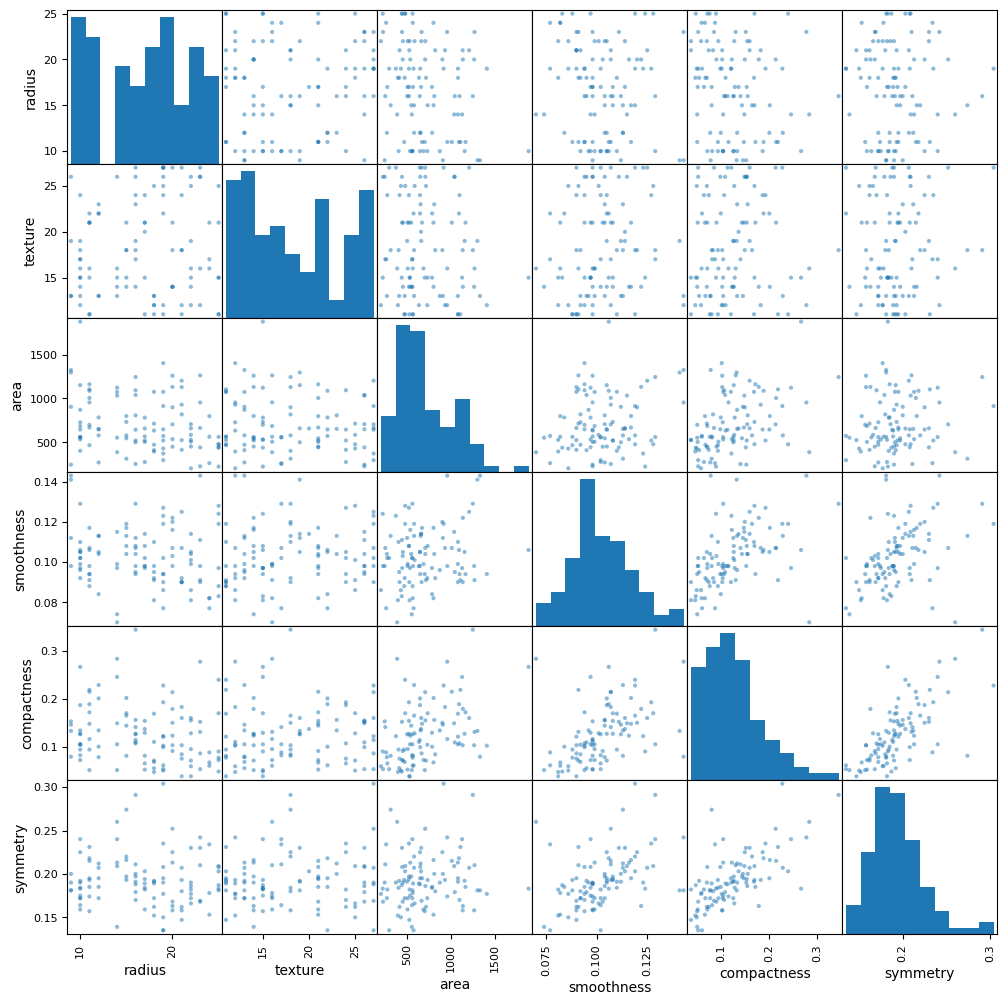

In [4]:
pd.plotting.scatter_matrix(dataset, figsize=(12, 12))

In [5]:
plt.hist(dataset[Y_COL_NAME])

(array([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 38.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

Error in callback <function flush_figures at 0x7f95f9c92160> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
datacamp_vif_data = pd.DataFrame()
datacamp_vif_data['Feature'] = X_train.columns
datacamp_vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
datacamp_vif_data

,Feature,VIF
0,radius,14.948782
1,texture,13.314682
2,area,6.447808
3,smoothness,52.576707
4,compactness,10.139439
5,symmetry,63.072250


In [8]:
class RobustMinMaxScaler:
    def __init__(self, qa: float, qb: float):
        self.q_r = [qa, qb]

    def fit(self, X, y=None):
        [self.qas, self.qbs] = np.quantile(X, self.q_r, axis=0)
        return self

    def transform(self, X):
        scaledX = (X - self.qas) / (self.qbs - self.qas)
        return scaledX

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [10]:
import statsmodels.api as sm

y_bin = label_binarize(y_train, classes=y_train.unique())
model = sm.Logit(y_bin, X_train)
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.284105
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Dec 2025   Pseudo R-squ.:                  0.5833
Time:                        22:07:40   Log-Likelihood:                -22.728
converged:                       True   LL-Null:                       -54.548
Covariance Type:            nonrobust   LLR p-value:                 2.145e-12
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
radius       -3.04e-05      0.086     -0.000      1.000      -0.169       0.169
texture         0.0419      0.077      0.544      0.587      -0.109       0.193
area            0.0090      0.003      3.408      0.001       0.004       0.014
smoothness   -101.2380     39.267     -2.578      0.010    -178.200     -24.276
compactness    53.6447     15.634      3.431      0.001      23.004      84.286
symmetry       -7.3564     19.793     -0.372      0.710     -46.151      31.438
===============================================================================
"""

In [11]:
datacamp_vif_data

,Feature,VIF
0,radius,14.948782
1,texture,13.314682
2,area,6.447808
3,smoothness,52.576707
4,compactness,10.139439
5,symmetry,63.072250


In [12]:
def create_model_using_params(params: dict) -> Pipeline:
    n_features_to_select = params["n_features_to_select"]
    scaler_name = params["scaler_name"]

    scaler = {
        "RobustMinMaxScaler": RobustMinMaxScaler(0.25, 0.75),
        "MinMaxScaler": MinMaxScaler(),
        "StandardScaler": StandardScaler(),
        "RobustScaler": RobustScaler(),
    }[scaler_name]

    model_params = {p: params[p] for p in ["solver"]}

    model = LogisticRegression(**model_params)
    pipe = Pipeline([
        ("scaler", scaler),
        ("selector", RFE(model, n_features_to_select=n_features_to_select)),
        ("model", model),
    ])
    return pipe

In [14]:
def objective_final(trial):
    params = dict(
        scaler_name=trial.suggest_categorical("scaler_name", [
            "RobustMinMaxScaler",
            "MinMaxScaler",
            "StandardScaler",
            "RobustScaler",
        ]),

        n_features_to_select=trial.suggest_int("n_features_to_select", 1, X.shape[1]),

        solver=trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    )

    model = create_model_using_params(params)

    cv = StratifiedKFold(n_splits=5, shuffle=True)

    sample_weight = compute_sample_weight("balanced", y_train)
    cv_params = {
        "model__sample_weight": sample_weight,
    }
    score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1, params=cv_params).mean()
    return score

In [15]:
final_study = optuna.create_study(study_name="FinalStudy", direction='maximize')
final_study.optimize(objective_final, n_trials=200)

[I 2025-12-09 22:07:55,254] A new study created in memory with name: FinalStudy
[I 2025-12-09 22:07:56,286] Trial 0 finished with value: 0.906984126984127 and parameters: {'scaler_name': 'RobustMinMaxScaler', 'n_features_to_select': 5, 'solver': 'liblinear'}. Best is trial 0 with value: 0.906984126984127.
[I 2025-12-09 22:07:56,988] Trial 1 finished with value: 0.9073015873015873 and parameters: {'scaler_name': 'RobustScaler', 'n_features_to_select': 1, 'solver': 'liblinear'}. Best is trial 1 with value: 0.9073015873015873.
[I 2025-12-09 22:07:57,579] Trial 2 finished with value: 0.9320634920634919 and parameters: {'scaler_name': 'RobustScaler', 'n_features_to_select': 2, 'solver': 'liblinear'}. Best is trial 2 with value: 0.9320634920634919.
[I 2025-12-09 22:07:57,615] Trial 3 finished with value: 0.8938095238095238 and parameters: {'scaler_name': 'StandardScaler', 'n_features_to_select': 4, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.9320634920634919.
[I 2025-12-09 22:07:57,649

In [16]:
final_study.best_params

{'scaler_name': 'StandardScaler',
 'n_features_to_select': 2,
 'solver': 'liblinear'}

In [26]:
best_model = create_model_using_params(final_study.best_params)
best_model.fit(X_train, y_train)

pickle.dump(best_model, open("best_model.pkl", "wb"))

best_model.score(X_test, y_test)

0.9

In [18]:
probs = best_model.predict_proba(X_test)
y_bin = label_binarize(y_test, classes=best_model.classes_)
np.concatenate([y_bin, probs], axis=1)

array([[1.        , 0.00830774, 0.99169226],
       [1.        , 0.02854059, 0.97145941],
       [1.        , 0.04658047, 0.95341953],
       [1.        , 0.01429942, 0.98570058],
       [1.        , 0.58343317, 0.41656683],
       [1.        , 0.42535928, 0.57464072],
       [1.        , 0.04092303, 0.95907697],
       [0.        , 0.79083952, 0.20916048],
       [1.        , 0.4254762 , 0.5745238 ],
       [1.        , 0.00234808, 0.99765192],
       [1.        , 0.02278935, 0.97721065],
       [1.        , 0.00847231, 0.99152769],
       [1.        , 0.38009767, 0.61990233],
       [1.        , 0.0082315 , 0.9917685 ],
       [0.        , 0.50741263, 0.49258737],
       [1.        , 0.00937341, 0.99062659],
       [0.        , 0.54569397, 0.45430603],
       [1.        , 0.0074259 , 0.9925741 ],
       [0.        , 0.00187826, 0.99812174],
       [1.        , 0.44302354, 0.55697646]])

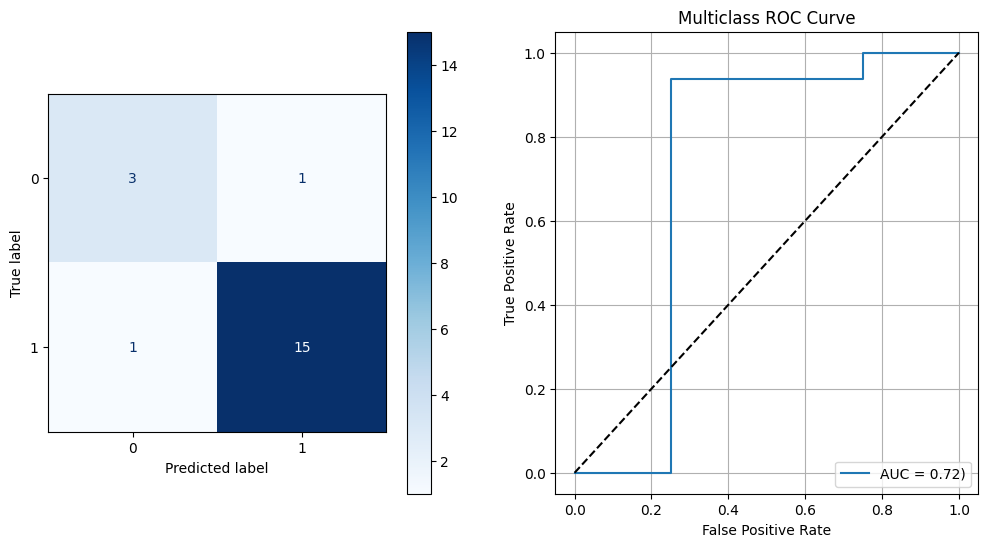

In [19]:
axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=axs[0])
plt.grid(False)
axs[0].grid(False)

probs = best_model.predict_proba(X_test)

y_bin = label_binarize(y_test, classes=best_model.classes_)

fpr, tpr, _ = roc_curve(y_bin, probs[:, 1])
roc_auc = auc(fpr, tpr)

ax = axs[1]
label = f'AUC = {roc_auc:.2f})'
ax.plot(fpr, tpr, label=label)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curve')
ax.legend(loc='lower right')
ax.grid(True)

